<img src="architecture.png" />

### Import module

In [1]:
import numpy as np 
import pycim as cim

### Simulating the Evolution of OPO

#### Set input parameters

In [2]:
# Initialize input
device = cim.simulation.device()
setup = cim.simulation.setup()
## Set physical layer parameters, it is not recommended to modify them after setting them
# Set the total system loss, normal : dB
device.loss = 10**(-11/10)
# Set the gain coefficient of nonlinear media, normal: W^(-1/2)
device.kappa = 130 * device.c 
# Set the length of nonlinear media, normal : m
device.L_ppln = 0.05 

## Set application layer parameters, which can be modified according to different scenarios
# Set the number of wheels to run in the cavity
setup.round_number = 1000
setup.N = 20
setup.couple_matrix = np.zeros((setup.N,setup.N))
setup.intensity = np.zeros(setup.round_number,)
# Set pump scheduling
setup.pump_schedule = np.sqrt( 10e-5 * np.linspace(1,setup.round_number,setup.round_number) )

#### Single simulation

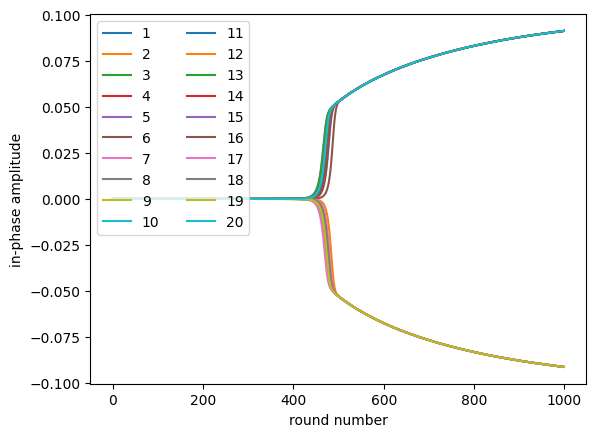

In [4]:
# Set the simulation model as the "discrete" model and the numerical solution algorithm as the "RK45" algorithm. Pass in the physical layer and application layer parameters for a single simulation, and return the in-phase component and gain of OPO as the return value
sol_info,gain = cim.simulation.singleSimulation( device , setup , model="discrete" , solver="RK45")
# Changes in the in-phase component of OPO in the cavity
cim.analyzer.inPhase_graph(sol_info,setup)

#### Measurement of simulation results

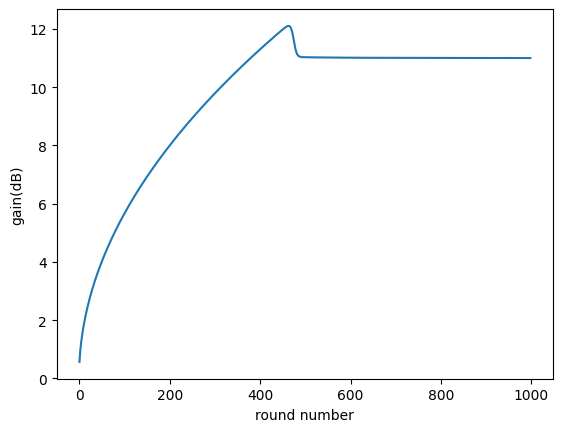

In [5]:
# Changes in gain obtained by OPO in the cavity
cim.analyzer.gain_graph(gain,setup)

In [9]:

SaturationTime = cim.analyzer.findSaturationTime(gain,setup)
SaturationAmplitude = cim.analyzer.getSaturationAmplitude(gain,sol_info,setup)
SaturationPower = cim.analyzer.getSaturationPower(gain,setup)
print(f"OPO saturation time:{SaturationTime} rounds\n\
OPO amplitude at saturation:{SaturationAmplitude}\nPump power at saturation:{SaturationPower}\n")

OPO saturation time:464 rounds
OPO amplitude at saturation:0.01093035795753226
Pump power at saturation:0.15247950681976907



### The process of solving MAX-CUT problems

#### Set application layer parameters

In [10]:
## Set application layer parameters, which can be modified according to different scenarios
# Set the number of wheels to run in the cavity
setup.round_number = 1000
# Read the data of the coupling matrix
setup.couple_matrix = cim.utils.read_J("pycim/data/20.txt")
# Set coupling strength
setup.intensity = 0.03 * np.ones(setup.round_number,)
# Set up pump scheduling plan
p_coeffi = 5
setup.pump_schedule = np.sqrt( p_coeffi * 1e-5 * np.linspace(1,setup.round_number,setup.round_number) )

#### Single simulation

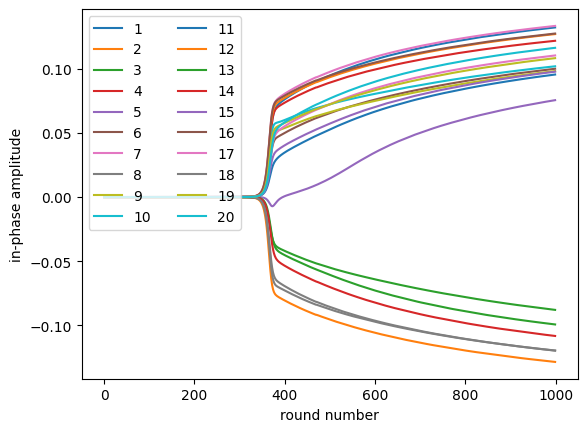

In [11]:
# Set the simulation model as the "discrete" model and the numerical solution algorithm as the "RK45" algorithm. Pass in the physical layer and application layer parameters for a single simulation, and return the in-phase component and gain of OPO as the return value
sol_info,gain = cim.simulation.singleSimulation( device , setup , model="discrete" , solver="RK45")
# Display the variation of OPO in-phase component in the cavity
cim.analyzer.inPhase_graph(sol_info,setup)

#### Solving the sampling results of information

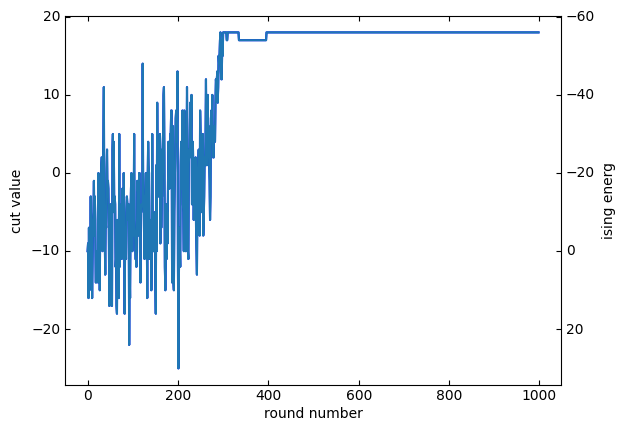

In [12]:
# The variation of cut_ralue value during the solving process
cim.sampler.cutvalue_graph(sol_info,setup)

In [13]:
SolutionTime = cim.sampler.getSolutionTime(sol_info,setup)
cut = cim.sampler.getCutValue(sol_info,setup)
sol = cim.sampler.getSolution(sol_info,setup)
print(f"The time when the optimal solution is first found:{SolutionTime} rounds\n\
Find the optimal classification configuration for the solution:{sol}\n\
The maximum cut value of the optimal solution:{cut}\n")

The time when the optimal solution is first found:294 rounds
Find the optimal classification configuration for the solution:[ 1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.
  1.  1.]
The maximum cut value of the optimal solution:18.0



### Performance evaluation

In [14]:
# Using the CUT obtained by SA algorithm as a benchmark to evaluate the accuracy of CIM solution
cut_sa = cim.competitor.SA(setup.couple_matrix)
accuracy = cim.sampler.getAccuracy(sol_info,setup,based_cut=cut_sa)
print(f"cut_sa:{cut_sa}\naccuracy:{accuracy}\n")

cut_sa:15.0
accuracy:1.2



#### Set different pump scheduling schemes

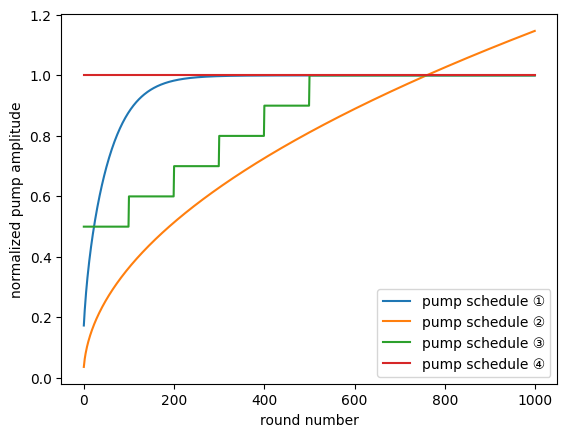

In [15]:
from matplotlib import pyplot as plt

t = np.linspace(1,setup.round_number,setup.round_number)
coeffi =  np.sqrt( np.tanh( 0.01 * ( t + 2 ) ) )
pump_amplitude1 = np.sqrt( (coeffi**2)  * 5e-5 *  760)
pump_amplitude2 = np.sqrt( 5e-5 * t)
coeffi_3 = np.zeros(1000,)
coeffi_3[:100] = 0.5
coeffi_3[100:200] = 0.6
coeffi_3[200:300] = 0.7
coeffi_3[300:400] = 0.8
coeffi_3[400:500] = 0.9
coeffi_3[500:600] = 1.0
coeffi_3[600:] = 1.0
pump_amplitude3 = np.sqrt((coeffi_3**2) * 5e-5 * 760)
pump_amplitude4 = np.sqrt(np.ones(1000,) * 5e-5*760)

plt.plot(pump_amplitude1/(np.sqrt(5e-5*760)),label='pump schedule ①')
plt.plot(pump_amplitude2/(np.sqrt(5e-5*760)),label='pump schedule ②')
plt.plot(pump_amplitude3/(np.sqrt(5e-5*760)),label='pump schedule ③')
plt.plot(pump_amplitude4/(np.sqrt(5e-5*760)),label='pump schedule ④')
plt.xlabel('round number')
plt.ylabel("normalized pump amplitude")
plt.legend()

#### Multiple simulations to evaluate the success rate of the solution

In [16]:
step = 10
cut_list = cim.simulation.multiSimulation( device , setup , step , model="discrete" , solver="RK45" )
SuccessRate = cim.sampler.getSuccessRate(cut_list,based_cut = 18)
ave_cut = cim.sampler.getAveCutValue(cut_list,step)
print(f"SuccessRate:{SuccessRate}\nave_cut:{ave_cut}\n")

SuccessRate:1.0
ave_cut:18.0



### Simulate with other models, and the operation is the same, for example, using the c-number model below

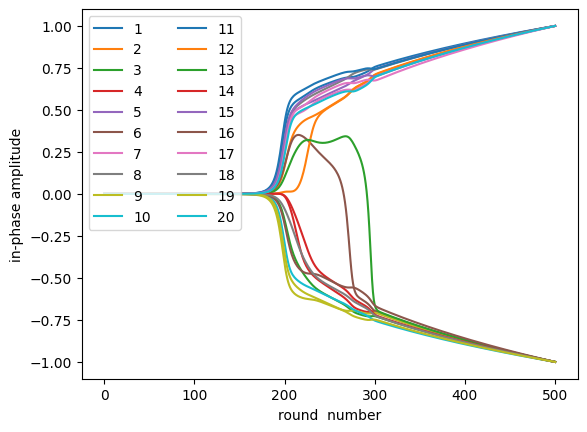

In [17]:
# Initialize input
setup = cim.simulation.setup()
## Set application layer parameters, which can be modified according to different scenarios
# Set the number of wheels to run in the cavity
setup.round_number = 500
setup.couple_matrix = cim.utils.read_J("pycim/data/20.txt")
def pump_schedule(t):
    p_coeffi = 5
    return np.sqrt( (p_coeffi/1000) * t )
def intensity(t):
    return 0.03
setup.intensity = intensity
setup.p = pump_schedule
# #Set the simulation model as the "c-number" model and the numerical solution algorithm as the "RK45" algorithm, perform a single simulation, and return the in-phase component and gain of OPO as the return value
sol_info = cim.simulation.singleSimulation( device , setup , model="c-number" , solver="RK45")
cim.analyzer.inPhase_graph(sol_info,setup)

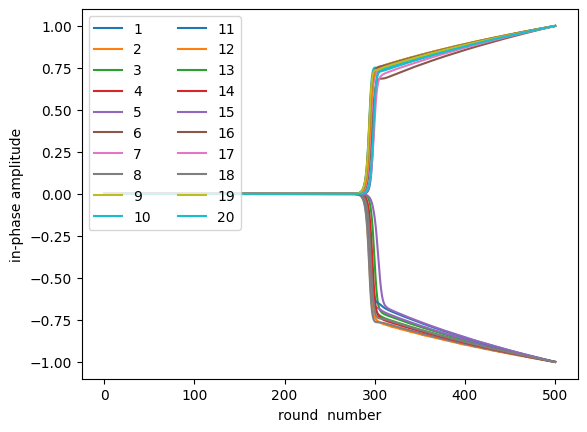

In [18]:
# Initialize input
setup = cim.simulation.setup()
## Set application layer parameters, which can be modified according to different scenarios
# Set the number of wheels to run in the cavity
setup.round_number = 500
setup.couple_matrix = cim.utils.read_J("pycim/data/20.txt")
def pump_schedule(t):
    p_coeffi = 5
    return np.sqrt( (p_coeffi/1000) * t )
def intensity(t):
    return 0.03
setup.intensity = intensity
setup.p = pump_schedule
# Set the simulation model as the "meanFiled" model and the numerical solution algorithm as the "RK45" algorithm, \
# perform a single simulation, and return the in-phase component and gain of OPO as the return value
sol_info = cim.simulation.singleSimulation( device , setup , model="meanFiled" , solver="RK45")
cim.analyzer.inPhase_graph(sol_info,setup)

### Threshold behavior of DOPO

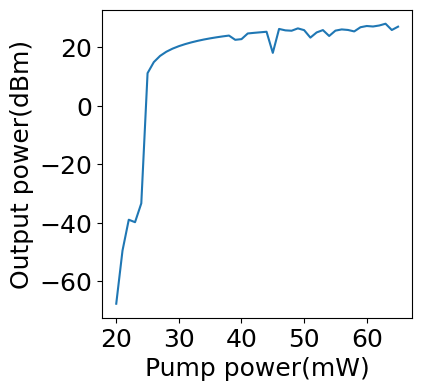

In [19]:
import matplotlib.pyplot as plt # Import pyplot library for drawing
if __name__ == '__main__':
    setup.N = 1 # Set the number of DOPOs
    setup.round_number = 1000 # Set to operate in the cavity
    start,end = 20,65
    pump =  np.sqrt( np.linspace(20,65,65-20+1) / 38 ) # Set the pump power range
    max_inphase = np.zeros_like(pump) # Initialize parameters to represent the amplitude of the steady-state DOPO in-phase component
    output_power = np.zeros_like(pump) # Initialize parameters to represent steady-state DOPO output power
    for i in range( len(pump) ):
        def pump_schedule(t): 
            return pump[i]
        setup.p = pump_schedule # Set pump power
        # Set the simulation model as the "c-number" model and the numerical solution algorithm \
        # as the "RK45" algorithm. Pass in the physical layer and application layer parameters \
        # for a single simulation, and return the in-phase component of OPO as the value
        sol_info = cim.simulation.singleSimulation( device , setup , model="c-number" \
                                                , solver="RK45")        
        c = sol_info.y[0:setup.N][0] # DOPO in-phase component amplitude
        max_inphase[i] = abs(c[-1]) # Steady state DOPO in-phase component amplitude
    output_power = 10 * np.log10(1000 * (max_inphase**2)) # Steady state DOPO output power
    xdata = np.linspace( start,end,end-start+1 )
    plt.figure(figsize=(4, 4))
    plt.plot(xdata,output_power)
    plt.xlabel("Pump power(mW)",fontsize=18)
    plt.ylabel("Output power(dBm)",fontsize=18)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=18) 
    plt.show()

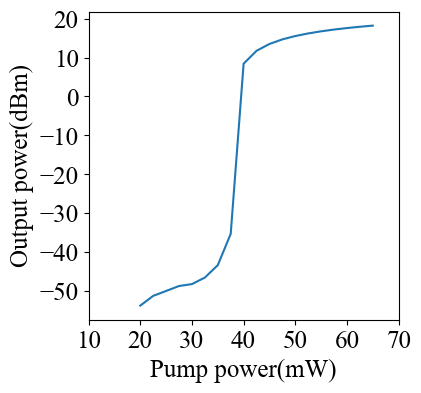

In [21]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'
if __name__ == '__main__': 
    setup.N = 1
    setup.couple_matrix = np.zeros((setup.N,setup.N))
    setup.intensity = 0.03 * np.ones(setup.round_number,)
    start = 8 
    end = 26
    init_Ep = np.sqrt(np.linspace(start,end,end-start+1) * 50 * 5e-5)
    output_power = np.zeros(end-start+1,)
    a = np.zeros(end-start+1,)
    for p in range(end-start+1):
        if( init_Ep[p] < np.sqrt(800*5e-5)):
            setup.round_number = 20000
        else:
            setup.round_number = 1500

        setup.pump_schedule = init_Ep[p] * np.ones(setup.round_number,)
        c,gain = cim.simulation.singleSimulation( device , setup , model="discrete" \
                                                , solver="RK45")   
        max_inphase = max(abs(c[-1]))
        output_power[p] = 10 * np.log10(1000 * (max_inphase**2) * (1/device.loss))
        a[p] = np.log10(1000 * (max_inphase**2))

    plt.figure(figsize=(4, 4))
    xdata = np.linspace(start,end,end-start+1) * 50 * 5e-2
    plt.plot(xdata,output_power)
    plt.xlabel("Pump power(mW)",fontsize=18)
    plt.ylabel("Output power(dBm)",fontsize=18)
    plt.xlim(10,70)
    plt.xticks(fontsize=18) 
    plt.yticks(fontsize=18) 
    # print(f"output_power:{output_power}")
    plt.show()